In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Content Based Recommendation**

In this section, we will implement **Content Based Recommendation** using the Amazon dataset.
* We will use the tf-idf vectorizer to extract features from description and details.
* We will use the cosine similarity to find similar Pet related products.

## **Reading dataset adn Filtering and Reset index in one line**

The Pet supplies dataset contains 100,000 ratings from 1000 users on 1700 Pet supplies products. The dataset is available at [Here]https://amazon-reviews-2023.github.io/). We will use the 100k dataset. The dataset is available in the `RecommendationSystem` folder.

Let's inspect the dataset by looking at the columns and the first few rows.

Since the dataset is too big, so we only use the top 10% rows bsaed on rating_number,
And we reset index to a sequential ordrer starting 0 and drop the old index.

In [11]:
import json
import pandas as pd
import torch

# Step 1: Define the path to the metadata file
metadata_path = "/content/drive/Shareddrives/RecommendationSystem/meta_Pet_Supplies.jsonl"

# Step 2: Read the data and store it in a list
data = []
with open(metadata_path, 'r') as fp:
    for line in fp:
        data.append(json.loads(line.strip()))

# Step 3: Create a pandas DataFrame and name it 'metadata'
metadata = pd.DataFrame(data)

# Step 4: Filter and reset index in one line
# - Filtering: Keeps only the rows where rating_number is in the top 10% based on the 90th percentile.
# - Resetting index: It resets the index to a sequential order starting from 0 and drops the old index.
quantile = 0.9
metadata = metadata[metadata['rating_number'] > metadata['rating_number'].quantile(quantile)].reset_index(drop=True)

# Step 5: Display the columns of the filtered DataFrame 'metadata'
display(pd.DataFrame(metadata.columns, columns=['columns']).T)


# Check if GPU is available and set the device accordingly.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
columns,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author


GPU is not available, using CPU instead.


**For Column Definition **
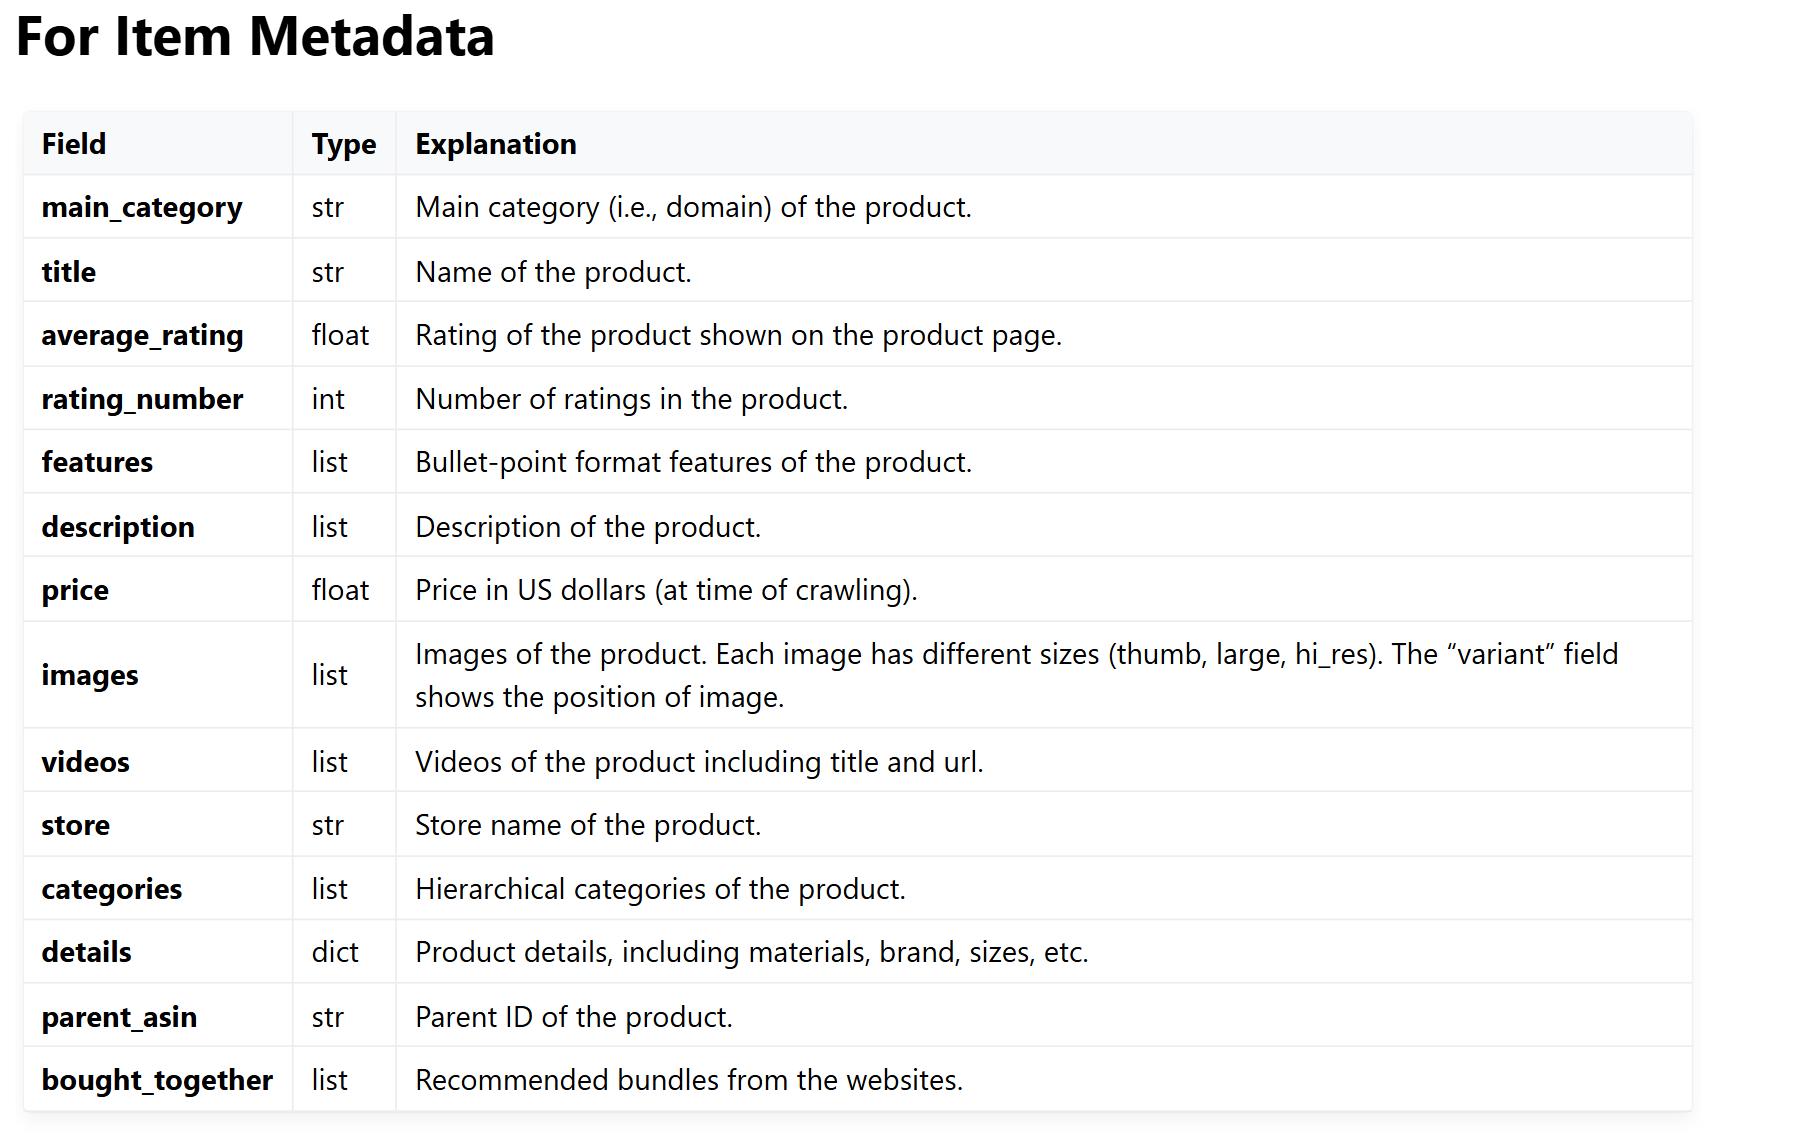

In [ ]:
metadata.head(20)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Pet Supplies,"SlowTon Dog Vest Harness, Mesh Breathable Pet ...",4.5,348,[New Match and Well Made --- The chest part of...,[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],SlowTon,"[Pet Supplies, Dogs, Collars, Harnesses & Leas...","{'Size': 'Large', 'Color': 'Purple', 'Pattern'...",B07DYM6LXD,None,NaN,NaN
1,Tools & Home Improvement,Reptile lamp Stand Fixed Bracket - Terrarium L...,4.1,321,[【Wide Application】The floor light holder can ...,[],36.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Reptile lamp Stand Fixed Bracket -...,Svnry,"[Pet Supplies, Reptiles & Amphibians, Terrariu...","{'Brand': 'Svnry', 'Special Feature': 'Lightwe...",B08YR694LN,None,NaN,NaN
2,Pet Supplies,Primalvore Free-Range Bone Broth for Dogs &Cat...,4.2,846,[GENTLY SUPPORTS MOBILITY WITHOUT THE USE OF P...,[],49.97,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Primalvore: Organic Bone Broth for...,Primalvore,"[Pet Supplies, Dogs, Food, Food Toppers]","{'Brand': 'Primalvore', 'Flavor': 'Mix Pack Be...",B07P5VHBS6,None,NaN,NaN
3,Pet Supplies,Cichlid Gold Fish Food Large Pellet Floating T...,4.7,716,"[Hikari Sales Usa Inc, LARGE, 8.8 OUNCE]",[Cichlid Gold fish food large pellet floating ...,9.62,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Hikari Cichlid Gold Fish Food', 'u...",Hikari,"[Pet Supplies, Fish & Aquatic Pets, Food]","{'Is Discontinued By Manufacturer': 'No', 'Pro...",B008NSGB5E,None,NaN,NaN
4,Pet Supplies,Pawprints Pet Memorial Frame with Pawprints Le...,4.9,2950,[Beautiful dog memorial frame with a sentiment...,[],24.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'A gift to treasure and remember yo...,Pawprints Left by You Memorial Gifts,[],{'Brand': 'Pawprints Left by You Memorial Gift...,B0BTKL8P4X,None,NaN,NaN
5,Pet Supplies,Aquarium Heater Submersible 50W/200W/300W Fish...,4.3,415,[✅Upgraded Heater - Our aquarium heater is mad...,[],18.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Outdoor pond heater #Pets #Fish #P...,Supyouleg,"[Pet Supplies, Fish & Aquatic Pets, Aquarium H...",{'Package Dimensions': '15.07 x 3.82 x 2.24 in...,B085Y66BVM,None,NaN,NaN
6,Pet Supplies,PetSafe Exterior / Interior Cat Door: Staywell...,4.5,2341,[PET SIZE: The large flap opening is perfect f...,[The PetSafe Staywell Big Cat/Small Dog Pet Do...,26.95,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'If you think you'll need the space...,PetSafe,"[Pet Supplies, Cats, Cat Doors, Steps, Nets & ...","{'Size': 'Medium', 'Brand': 'PetSafe', 'Color'...",B081W4G8K7,None,NaN,NaN
7,Pet Supplies,Classic Plaid Dog Sweater - Puppy Festive Wint...,4.5,1376,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],HSKLOCK,"[Pet Supplies, Dogs, Apparel & Accessories, Sw...","{'Target Species': 'Dog', 'Neck Size': '10 inc...",B07WTCNC1W,None,NaN,NaN
8,Pet Supplies,ASPCA Cat House & Cat Scratcher w/Bonus Catnip...,4.7,9248,[Cardboard cat house 2 in 1 with scratching bo...,[Give kitty a relaxing place to play and hide ...,21.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Cat Scratching Playhouse! #foundit...,ASPCA,"[Pet Supplies, Cats, Beds & Furniture, Cat Hou...","{'Brand': 'ASPCA', 'Product Dimensions': '18.2...",B0843HPZKY,None,NaN,NaN
9,Pet Supplies,Nutramax Dasuquin Joint Health Supplement for ...,4.3,641,"[Joint Health Support for Cats: Dasuquin, the ...",[Dasuquin for Cats Soft Chews is a premium joi...,9.68,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Nutramax Laboratories Intro', 'url...",Dasuquin,"[Pet Supplies, Cats, Health Supplies, Hip & Jo...","{'Brand': 'Dasuquin', 'Unit Count': '84.0 Coun...",B09J5FJYMJ,None,NaN,NaN


# **1. Preprocessing for Content-Based Recommendation**

Preprocessing ensures that the data is clean, consistent, and transformed into a machine-readable format for building a recommendation system.

## **Goals of Preprocessing**
- **Transform textual data** into a numerical format for similarity calculations.
- **Combine product information** from multiple columns to create a unified representation for each product.

## **Techniques Used**

### **1. Variation Key**
- A `variation_key` combines the normalized product title and its specific attributes (like size or color) from the `details` column.
- **Why Use It?**
  - To uniquely identify variations of similar products (e.g., "Dog Bed Large" vs. "Dog Bed Small").
  - Enhances the quality of recommendations by including distinguishing features.

### **2. Combined Text**
- Aggregates key textual fields (`title`, `features`, `description`, and `categories`) into a single text column (`combined_text`).
- **Why Use It?**
  - Provides a holistic representation of the product for similarity calculations.

### **3. TF-IDF Vectorization**
- Converts text into a numerical matrix where each term is weighted based on its importance within the document and the entire corpus.
- **Parameters**:
  - `max_df=0.8`: Excludes terms that appear in more than 80% of the documents (e.g., stopwords).
  - `min_df=2`: Excludes terms that appear in fewer than 2 documents to remove noise.
- **Why Use It?**
  - Highlights unique and informative terms for each product while filtering out overly common or rare terms.

### **4. **Parameters of TF-IDF**:
   - `max_df=0.8`: Ignores terms that appear in more than 80% of documents to reduce noise from overly common words.
   - `min_df=2`: Excludes terms appearing in fewer than 2 documents, ensuring rare terms don’t skew the model.



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Step 1: Create a 'variation_key' column
# Normalize the title and include additional attributes like size, color, etc.
def create_variation_key(row):
    # Normalize the title
    title_normalized = row['title'].lower() if isinstance(row['title'], str) else ''

    # Concatenate feature-specific attributes
    details_str = ''
    if isinstance(row['details'], dict):
        details_str = ' '.join([f"{key}: {value}" for key, value in row['details'].items()])

    # Combine the normalized title and details
    return f"{title_normalized} {details_str}".strip()

# Apply the function to create the 'variation_key' column
metadata['variation_key'] = metadata.apply(create_variation_key, axis=1)

# Step 2: Create a 'combined_text' column
# Combine relevant columns into a single text column for vectorization
text_columns = ['title', 'features', 'description', 'categories']

# Aggregate the text data from the specified columns
def combine_text(row):
    combined = []
    for col in text_columns:
        value = row[col]
        if isinstance(value, list):
            combined.extend(value)  # Add list items directly
        elif pd.notnull(value):
            combined.append(value)  # Add non-null single values
    return ' '.join(map(str, combined))  # Join all parts into a single string

# Generate the 'combined_text' column
metadata['combined_text'] = metadata.apply(combine_text, axis=1)

# Include the 'variation_key' in the combined text
metadata['combined_text'] = metadata['variation_key'] + ' ' + metadata['combined_text']

# Step 3: Initialize the TF-IDF vectorizer
# The TF-IDF vectorizer will extract features from the 'combined_text' column
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)

# Step 4: Fit and transform the text data
# Transform the 'combined_text' column into a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(metadata['combined_text'])

# Step 5: Display results
# Show the size of the resulting matrix
print(f"Matrix contains {tfidf_matrix.shape[0]} products and {tfidf_matrix.shape[1]} unique terms.")

# Display a sample of the processed columns
pd.set_option('display.max_colwidth', None)
print(metadata[['title', 'variation_key', 'combined_text']].head(10))




Matrix contains 49273 products and 42615 unique terms.
                                                                                                                                                                                                     title  \
0                   SlowTon Dog Vest Harness, Mesh Breathable Pet Harness with Adjustable Neck and Chest Strap & Quick Release Buckle, for Small Medium Large Dogs Daily Use Walking Vehicle Travel (PU,L)   
1                        Reptile lamp Stand Fixed Bracket - Terrarium Large Reptile Lamp Adjustable Metal lamp Holder, Used for Amphibians and Lizards, Tortoise and Snakes and Other Cold-Blooded Animals   
2  Primalvore Free-Range Bone Broth for Dogs &Cats, Mobility Formula w/Collagen Peptides for Hip & Joints, Digestion, Skin & Coat and Hydration. Grain Free, Human Grade, Made in USA. Beef & Chicken 6 Pk   
3                                                                                                                        

## **2. Inspecting the TF-IDF Model**

### **Steps 5–8: Understanding Important Terms**

- The **TF-IDF matrix** represents products (rows) and terms (columns). Each entry is the TF-IDF score of a term in a product’s combined text.
- **Purpose**:
  - Analyze key terms to understand what the model considers important.
  - Identify distinguishing terms like "dog," "cat," or "toy."

In [22]:
# The resulting `tfidf_matrix` can now be used for similarity calculations

# Step 6: Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Step 7: Calculate average TF-IDF scores for each term
# Use `.mean()` to calculate the mean along the correct axis
avg_tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

# Step 8: Sort terms by average TF-IDF score in descending order
sorted_indices = np.argsort(avg_tfidf_scores)[::-1]  # Descending order
sorted_terms = [feature_names[i] for i in sorted_indices]

# Step 9: Print the top N popular terms
N = 20  # Number of popular terms to display
print(f"\nTop {N} popular terms by average TF-IDF score:")
for i in range(N):
    print(f"{i + 1}. {sorted_terms[i]}")




Top 20 popular terms by average TF-IDF score:
1. dog
2. cat
3. dogs
4. small
5. toys
6. food
7. collar
8. cats
9. size
10. bed
11. large
12. water
13. toy
14. harness
15. easy
16. item
17. medium
18. pets
19. fish
20. leash


###Inspect the TF-IDF Model

The code snippet below allows us to inspect the TF-IDF model by focusing on the top 20 popular terms identified in the dataset. These terms, such as 'dog', 'cat', 'food', and 'leash', represent the most significant terms based on their TF-IDF scores. We construct a sparse DataFrame from the TF-IDF matrix and filter it to include only the columns corresponding to these popular terms. This enables a closer look at the scores associated with these terms across different documents. The result provides a clear understanding of how these key terms are distributed within the dataset.

In [19]:
# Top 20 popular terms
top_n = 20
popular_terms = ['dog', 'cat', 'dogs', 'food', 'toys', 'cats', 'collar', 'small', 'water',
                 'bed', 'size', 'easy', 'pets', 'toy', 'harness', 'large', 'fish', 'soft',
                 'collars', 'leash']

# Step: Create DataFrame for the TF-IDF matrix
columns = vectorizer.get_feature_names_out()
tfidf_model_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=columns)

# Heading for clarity in the output
print("\nInspect the TF-IDF Model\n")
print("What does the TF-IDF model look like?")
print(f"Let us inspect the columns with popular terms like {', '.join(popular_terms[:5])}, etc.")

# Step: Extract the DataFrame for the popular terms
popular_terms_df = tfidf_model_df[popular_terms]

# Display the popular terms DataFrame
print("\nTF-IDF Scores for Popular Terms:")
popular_terms_df.head()


Inspect the TF-IDF Model

What does the TF-IDF model look like?
Let us inspect the columns with popular terms like dog, cat, dogs, food, toys, etc.

TF-IDF Scores for Popular Terms:


,dog,cat,dogs,food,toys,cats,collar,small,water,bed,size,easy,pets,toy,harness,large,fish,soft,collars,leash
0,0.109786,0,0.106529,0,0,0.045585,0.034528,0.058155,0,0,0.03882,0.037343,0,0,0.522883,0.089523,0,0,0.031256,0.10605
1,0,0,0,0,0,0,0,0,0,0,0.015205,0.04388,0,0,0,0.052597,0,0,0,0
2,0.033665,0.032948,0.065333,0.146341,0,0.048924,0,0.02774,0,0,0,0,0,0,0,0.016014,0,0,0,0
3,0,0,0,0.241611,0,0,0,0,0,0,0,0,0.034024,0,0,0.148056,0.292834,0,0,0
4,0.034649,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**The TF-IDF score** reflects how significant the word is in that product's description in relation to all other products. **Higher scores** indicate that the word is more distinctive to that product, while **lower or zero scores** indicate that the word is either too common or not present in the product's description.



## **Cosine Similarity Overview**

Cosine similarity measures the similarity between two vectors based on the cosine of the angle between them. It ranges from **0** (no similarity) to **1** (identical). This is particularly useful in recommendation systems where text or numerical features are converted into vectors, as it focuses on the direction of the vectors rather than their magnitude.

### **Formula**:

The formula for cosine similarity is:

$$
\cos(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x} \cdot \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$

- **Numerator**: Dot product of vectors \(\mathbf{x}\) and \(\mathbf{y}\) (e.g., product descriptions).
- **Denominator**: Product of vector magnitudes, ensuring normalization.


### **Key Properties**:
- **Independent of Magnitude**: Only measures direction, not size.
- **Bounded [0, 1]**: 0 means no similarity, 1 means identical.
- **Symmetric**: $\cos(\mathbf{x}, \mathbf{y}) = \cos(\mathbf{y}, \mathbf{x})$.


### **Why Use Cosine Similarity for Recommendations?**
- Efficiently compares products' text-based features (e.g., descriptions, titles) represented as TF-IDF vectors.
- Highlights semantic similarities, helping identify related products.

---

## **Integration with k-Nearest Neighbors (kNN)**

In this system:
1. **Input**: TF-IDF matrix representing products.
2. **Distance Metric**: Cosine similarity (`metric='cosine'`).
3. **Output**: Top \(n\) most similar products to the queried item.

This ensures recommendations are based on textual and semantic closeness.

In [23]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def get_content_based_recommendation(title, top_n=10, metric='cosine'):
    title_lower = title.lower()

    # Find exact match first
    matching_rows = metadata[metadata.title.str.lower() == title_lower]

    # If no exact match, try partial match
    if matching_rows.empty:
        print(f"No exact match found for the title '{title}', trying partial match...")
        matching_rows = metadata[metadata.title.str.contains(title_lower, case=False, na=False)]

    # If still no match, return None
    if matching_rows.empty:
        print(f"No products found matching '{title}'.")
        return None

    # Get matched product index
    idx = matching_rows.index[0]

    # Initialize NearestNeighbors with cosine similarity
    model = NearestNeighbors(n_neighbors=top_n, metric=metric)
    model.fit(tfidf_matrix)

    # Get similar products based on cosine similarity
    distances, similar_products = model.kneighbors(tfidf_matrix[idx], return_distance=True)

    # Convert results to DataFrame
    recommended_products = metadata.iloc[similar_products[0]]

    # Add similarity scores to the results
    recommended_products = recommended_products.copy()  # Avoid SettingWithCopyWarning
    recommended_products['similarity'] = distances[0]

    # Remove duplicate products and exclude the searched product
    recommended_products = recommended_products.drop_duplicates(subset="title")
    recommended_products = recommended_products[recommended_products.title.str.lower() != title_lower]

    # Sort by similarity in decending order
    recommended_products = recommended_products.sort_values(by='similarity', ascending=False)

    # Select columns to display, using the original text columns
    return recommended_products[['title', 'details', 'description', 'average_rating', 'rating_number', 'price', 'categories', 'similarity']]

# Example usage
title = 'cat food'
recommended_products = get_content_based_recommendation(title, top_n=10)

# Display recommendations if found
if recommended_products is not None:
    display(recommended_products)

No exact match found for the title 'cat food', trying partial match...


,title,details,description,average_rating,rating_number,price,categories,similarity
10858,"Blue Buffalo Basics Skin & Stomach Care, Grain Free Natural Adult Pate Wet Cat Food, Indoor Fish 3-oz cans (Pack of 24)","{'Brand': 'Blue Buffalo', 'Flavor': 'Fish', 'Age Range (Description)': 'Adult', 'Target Species': 'Cat', 'Item Form': 'Wet', 'Is Discontinued By Manufacturer': 'No', 'Product Dimensions': '11 x 8.25 x 2.95 inches; 4.5 Pounds', 'Item model number': '800431', 'Department': 'Food', 'Date First Available': 'June 8, 2012', 'Manufacturer': 'Blue Buffalo Company, Ltd', 'Country of Origin': 'USA', 'Domestic Shipping': 'Currently, item can be shipped only within the U.S. and to APO/FPO addresses. For APO/FPO shipments, please check with the manufacturer regarding warranty and support issues.', 'International Shipping': 'This item is not eligible for international shipping. Learn More'}","[Product Description, Ideal for cats with food sensitivities, BLUE Basics wet cat food is a limited-ingredient diet that features a single animal protein source. Grain free and made with real whitefish as the first ingredient, this paté-style canned cat food features the finest natural ingredients enhanced with vitamins and minerals. Made specifically to support the health of your adult cat and promote gentle digestion, this formula is free of corn, wheat, soy, dairy and eggs, and contains no chicken or beef., From the Manufacturer, BLUE Basics contains: Whitefish — A delicious, high-quality protein not typically used in cat food. Potatoes and Peas — Easily digestible carbohydrate sources. A Precise Blend of Veggies, Fruit and Micronutrients — These ingredients were selected for their nutritional value, and their capacity to help in the digestive process. An Optimal Blend of Omega 3 and 6 Fatty Acids — They help to support skin and coat health for cats with food sensitivities]",4.3,1268,39.84,"[Pet Supplies, Cats, Food, Wet, Canned]",6.789723e-01
1655,Solid Gold Wet Cat Food Shreds in Gravy - Canned Cat Food Made w/Real Tuna for Cats of All Ages - Five Oceans Grain Free Cat Wet Food for Sensitive Stomach & Overall Wellness - 12ct/3oz Can,"{'Brand': 'Solid Gold', 'Flavor': 'Tuna', 'Age Range Description': 'All Life Stages', 'Target Species': 'Cat', 'Item Form': 'Pate', 'Product Dimensions': '10.5 x 2.75 x 4.75 inches; 2.52 Pounds', 'Item model number': '41030', 'Date First Available': 'April 11, 2016', 'Manufacturer': 'Solid Gold'}","[A holistic food with premium ingredients, vitamins, minerals and amino acids your cat is sure to go crazy over! Grain and gluten free, this wet cat food is crafted with a carefully balanced combination of ingredients including tuna and tapioca and served in a gravy your cat will love. Our blended tuna recipe is a nutritionally complete and balanced meal, perfect for adult cats and growing kittens. May also be served as an accompaniment to dry food or as a tasty treat. Unleash your cat’s inner gold with our #1 canned cat food.]",4.3,842,22.68,"[Pet Supplies, Cats, Food, Wet, Canned]",6.775356e-01
5976,"""I and love and you"" Naked Essentials Canned Wet Cat Food - Grain Free, Tuna Recipe, 3-Ounce (Pack of 24)","{'Brand': 'I AND LOVE AND YOU', 'Flavor': 'Tuna Fintastic Stew (Tuna Fish)', 'Age Range Description': 'Adult', 'Target Species': 'Cat', 'Item Form': 'Grain', 'Product Dimensions': '2.56 x 2.56 x 1.5 inches; 4.5 Pounds', 'Item model number': 'Tuna Fintastic', 'Date First Available': 'May 22, 2016', 'Manufacturer': 'NatPets, LLC', 'Country of Origin': 'USA'}","[Better break out the can opener, human. I think your cat is drooling. Made with whole meat and real fruits + vegetables, our grain free, protein-packed Tuna Fantastic recipe will make your cat unconditionally love and adore you. Or, at the very least stop giving you looks of disdain.]",4.4,1660,40.99,"[Pet Supplies, Cats, Food, Wet, Canned]",6.661664e-01
13672,"AvoDerm Natural Grain Free Tuna & Crab Entree in Gravy Canned Wet Cat Food, 3-Ounce Cans, (Cas

###Summary:

The code implements a recommendation system that suggests similar products by analyzing text-based features (e.g., titles, descriptions) using TF-IDF vectorization and cosine similarity. By calculating similarity scores, it retrieves the most relevant items, making it ideal for displaying related products to users based on their current selection.